In [ ]:
!unzip miml-image-data.zip

Archive:  miml-image-data.zip
  inflating: miml-image-data.rar     
  inflating: original.zip            
  inflating: miml data.mat           


In [ ]:
get_ipython().system_raw("unrar x miml-image-data")

In [ ]:
!unzip original.zip

Archive:  original.zip
replace original/103.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: original/103.jpg        
  inflating: original/104.jpg        
  inflating: original/105.jpg        
  inflating: original/106.jpg        
  inflating: original/107.jpg        
  inflating: original/109.jpg        
  inflating: original/11.jpg         
  inflating: original/110.jpg        
  inflating: original/112.jpg        
  inflating: original/117.jpg        
  inflating: original/119.jpg        
  inflating: original/12.jpg         
  inflating: original/120.jpg        
  inflating: original/121.jpg        
  inflating: original/122.jpg        
  inflating: original/123.jpg        
  inflating: original/124.jpg        
  inflating: original/125.jpg        
  inflating: original/126.jpg        
  inflating: original/128.jpg        
  inflating: original/131.jpg        
  inflating: original/133.jpg        
  inflating: original/135.jpg        
  inflating: original/137.jpg        

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [ ]:
import numpy as np
import h5py
import cv2
import scipy.io as sio
import os
from skimage import io
from skimage.transform import resize

target_path = "miml data.mat"   
image_path = "original"     

y = sio.loadmat(target_path)
y = y['targets']
y = y.transpose()
y = np.array([[elem if elem == 1 else 0 for elem in row]for row in y])
x = []

for i in range(1,2001):
    print ("reading image:" + str(i) + ".jpg")
    img = image_path + "/" + str(i) + ".jpg"
    img = cv2.imread(img)
    img = cv2.resize(img,(100,100)) 
    img=cv2.addWeighted(img, 2, cv2.GaussianBlur(img, (3, 3), 3), -1, 0)
    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
    img = img.transpose((2,0,1))
    x.append(img)   
x = np.array(x)
f = h5py.File("dataset.h5")
f['x'] = x
f['y'] = y
f.close()

In [ ]:
import h5py
from sklearn.model_selection import train_test_split

def load():
    f = h5py.File("dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    return x_train, x_test, y_train, y_test
    

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')
import tensorflow as tf

x_train, x_test, y_train, y_test = load()

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train /= 255
x_test /= 255


model = Sequential()
model.add(Convolution2D(64, kernel_size=(3, 3),padding='same',input_shape=(3 , 100, 100)))
model.add(Activation('relu'))
from google.colab.patches import cv2_imshow
cv2_imshow(img)
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
cv2_imshow(img)
model.add(MaxPooling2D(pool_size=(2, 2)))
cv2_imshow(img)
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def ranking_loss(y_true, y_pred):
    y_true_ = tf.cast(y_true, tf.float32)
    partial_losses = tf.maximum(0.0, 1 - y_pred[:, None, :] + y_pred[:, :, None])
    loss = partial_losses * y_true_[:, None, :] * (1 - y_true_[:, :, None])
    return loss

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy', f1_m,precision_m,recall_m,ranking_loss])

check = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
history=model.fit(x_train, y_train, batch_size=32, epochs=20,callbacks=[check],validation_data=(x_test,y_test))

out = model.predict_proba(x_test)
out = np.array(out)

threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

print("best thresholds", best_threshold)
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

print("-"*40)
print("Matthews Correlation Coefficient")
print("Class wise accuracies")
print(accuracies)

print("other statistics\n")
total_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==y_pred[i]).sum() == 5])
print("Fully correct output")
print(total_correctly_predicted)
print(total_correctly_predicted/400.)
model.save('my_model.h5')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 202s 127ms/step - loss: 0.5424 - acc: 0.7473 - f1_m: 0.0916 - precision_m: 0.3096 - recall_m: 0.0663 - ranking_loss: 0.1685 - val_loss: 0.4786 - val_acc: 0.7740 - val_f1_m: 0.3267 - val_precision_m: 0.6250 - val_recall_m: 0.2238 - val_ranking_loss: 0.1481

Epoch 00001: val_acc improved from -inf to 0.77400, saving model to weights.01-0.77400.hdf5
Epoch 2/20
1600/1600 [==============================] - 201s 126ms/step - loss: 0.4362 - acc: 0.7950 - f1_m: 0.4379 - precision_m: 0.6740 - recall_m: 0.3302 - ranking_loss: 0.1346 - val_loss: 0.3967 - val_acc: 0.8190 - val_f1_m: 0.5491 - val_precision_m: 0.7149 - val_recall_m: 0.4487 - val_ranking_loss: 0.1220

Epoch 00002: val_acc improved from 0.77400 to 0.81900, saving model to weights.02-0.81900.hdf5
Epoch 3/20
1600/1600 [==============================] - 200s 125ms/step - loss: 0.3863 - acc: 0.8247 - f1_m: 0.5738 - precision_m: 0.7168 - 

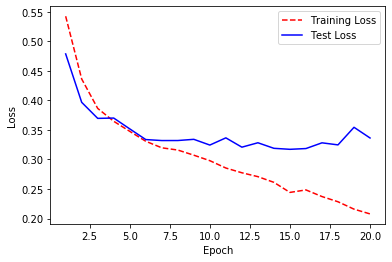

In [ ]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


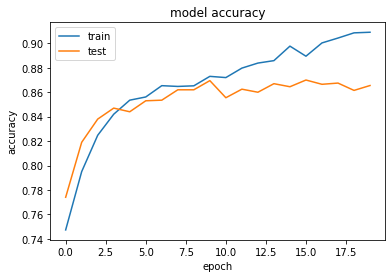

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# New Section

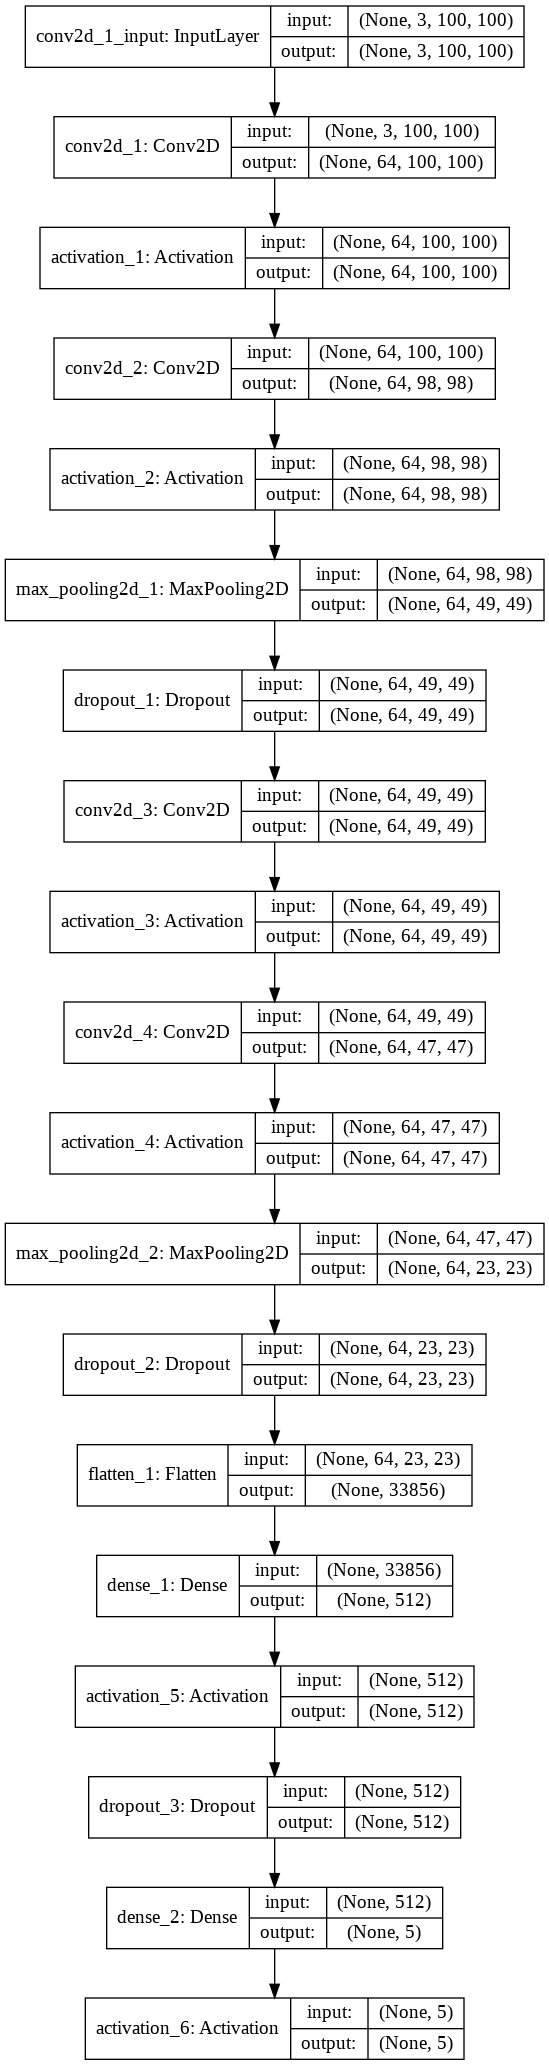

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
out = model.predict_proba(x_test)
out = np.array(out)

In [ ]:
out

array([[4.8673451e-03, 2.2357249e-01, 7.7909195e-01, 5.3851604e-03,
        1.8352541e-01],
       [2.1808773e-02, 5.0151348e-04, 4.2654973e-01, 9.9542737e-01,
        1.2179822e-02],
       [1.5891999e-02, 9.5889568e-03, 4.9101055e-01, 9.8596078e-01,
        3.7245750e-03],
       ...,
       [1.9523069e-01, 2.5009811e-03, 1.9142839e-01, 9.3726337e-01,
        9.6430480e-03],
       [3.0507147e-03, 1.0728526e-01, 7.1405876e-01, 3.0148029e-04,
        1.0328817e-01],
       [2.8317809e-02, 6.2769127e-01, 5.1555967e-01, 1.9626915e-03,
        1.3256395e-01]], dtype=float32)

In [ ]:
threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

In [ ]:
best_threshold

array([0.5, 0.3, 0.3, 0.3, 0.5])

In [ ]:
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

In [ ]:
y_pred

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0]])

In [ ]:
y_test

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [ ]:
hamming_loss(y_test,y_pred)

0.1505

In [ ]:
total_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==y_pred[i]).sum() == 5])

In [ ]:
total_correctly_predicted/400

0.5175

In [ ]:
total_correctly_predicted

207

In [ ]:
from IPython.display import Image

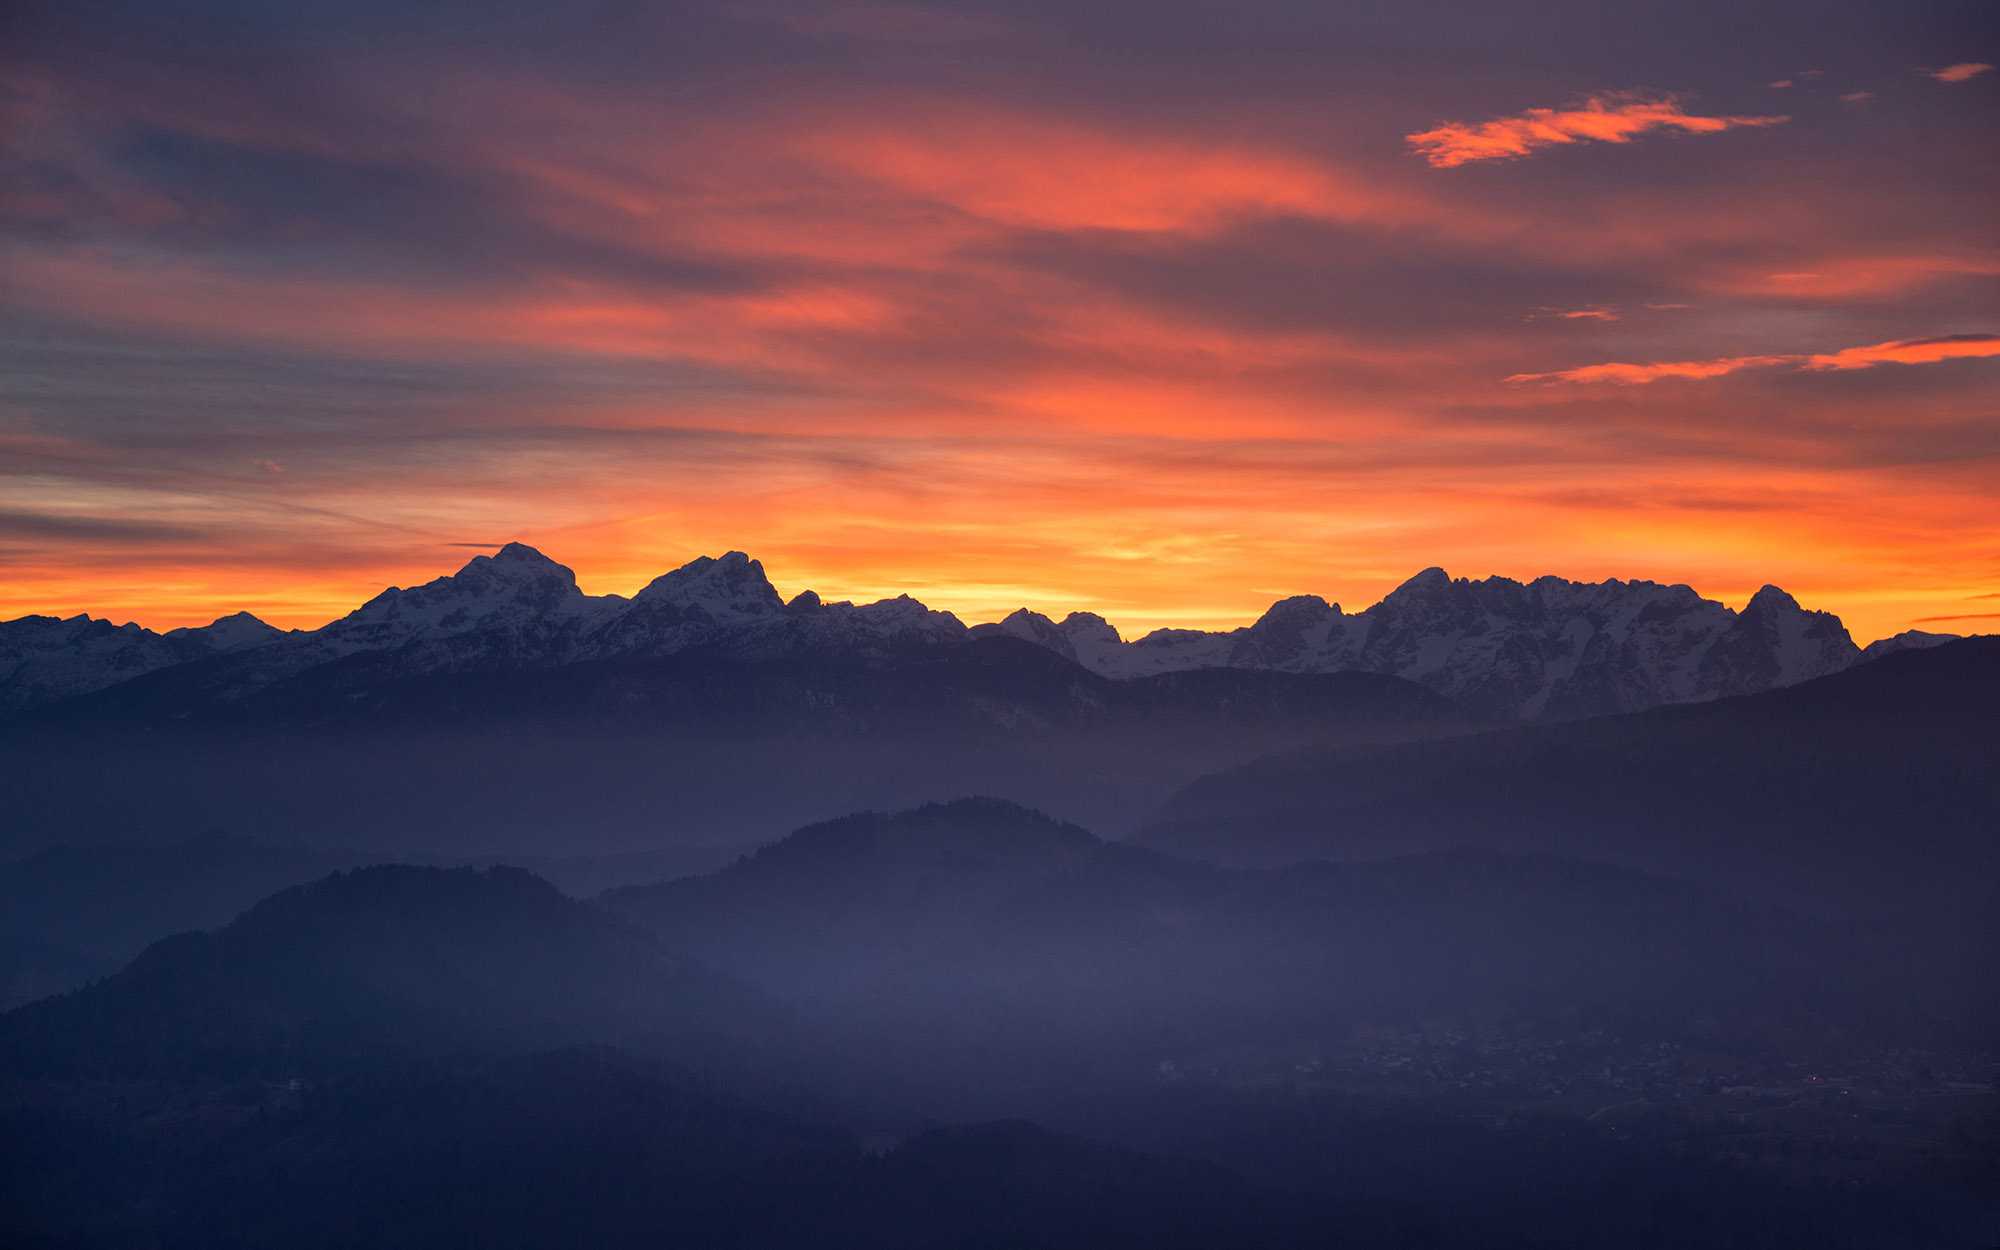

In [ ]:
Image(filename='test_image3.jpg')

In [ ]:
import cv2

In [ ]:
img=cv2.imread("test_image3.jpg")

In [ ]:
img.shape

(1250, 2000, 3)

In [ ]:
img=cv2.resize(img,(100,100))

In [ ]:
img.shape

(100, 100, 3)

In [ ]:
img=img.transpose((2,0,1))

In [ ]:
img=cv2.addWeighted(img, 2, cv2.GaussianBlur(img, (3, 3), 3), -1, 0)

In [ ]:
img.shape

(3, 100, 100)

In [ ]:
img=img.astype('float32')

In [ ]:
img=img/255

In [ ]:
img=np.expand_dims(img,axis=0)

In [ ]:
img.shape

(1, 3, 100, 100)

In [ ]:
pred=model.predict(img)

In [ ]:
pred

array([[2.9943457e-02, 1.6811083e-03, 1.5734024e-01, 9.8552901e-01,
        6.9549758e-05]], dtype=float32)

In [ ]:
y_pred=np.array([1 if pred[0,i]>=best_threshold[i] else 0 for i in  range(pred.shape[1])])

In [ ]:
y_pred

array([0, 0, 1, 1, 0])

In [ ]:
labels=['desert','mountains','sea','sunset','trees']

In [ ]:
[labels[i] for i in range(5) if y_pred[i]==1]

['sea', 'sunset']